In [1]:
%matplotlib inline

#System
import os
import shutil

#Base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from skimage.io import imread, imshow, imsave

#Keras
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from keras.layers import Dropout,BatchNormalization, Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint

#Preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical

#Models
from keras.applications.vgg16 import VGG16

#GPU
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto() 
config.gpu_options.allow_growth = True
sess = tf.Session(config=config) 
K.set_session(sess)

#Seed
seed = 99
np.random.seed(seed)
random.seed(seed)

Using TensorFlow backend.
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rv/anaconda3/lib/python3.7/site-packages/tensorflow/python/fra

## Генераторы данных

In [2]:
img_shape = 256
batch_size = 4
num_classes = 32

train_size = len(os.listdir(path="data/ADE20K_formated/train/img/img/"))
val_size = len(os.listdir(path="data/ADE20K_formated/val/img/img/"))

train_dir = "data/ADE20K_formated/train/"
val_dir = "data/ADE20K_formated/val/"

img_train_dir = train_dir + "img/img/"
mask_train_dir = train_dir + "mask/mask/"

img_val_dir = val_dir + "img/img/"
mask_val_dir = val_dir + "mask/mask/"

In [3]:
def dice_coef(y_true, y_pred, smooth=0.01):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [4]:
def data_gen(img_dir, mask_dir, num_classes, batch_size):
    img_folder = img_dir
    mask_folder = mask_dir
    num_classes = num_classes
    
    img_list = os.listdir(img_folder)
    random.shuffle(img_list)
    img_dir_size = len(img_list)
    
    for i in range(len(img_list)):
        img_list[i] = img_list[i].split(".")[0] #отделяем имя от формата
        
    c = 0
    while (True):
        img = np.zeros((batch_size, img_shape, img_shape, 3)).astype('float')
        mask = np.zeros((batch_size, img_shape, img_shape, num_classes)).astype("uint8")

        for i in range(c, c + batch_size):  

            train_img = cv2.imread(img_folder + '/' + img_list[i] + ".jpg") / 255.
            train_img =  cv2.resize(train_img, (img_shape, img_shape))

            img[i - c] = train_img 

            train_mask = cv2.imread(mask_folder + '/' + img_list[i] + ".png", cv2.IMREAD_GRAYSCALE)
            train_mask = cv2.resize(train_mask, (img_shape, img_shape), interpolation = cv2.INTER_NEAREST)
            train_mask = train_mask.reshape(img_shape, img_shape, 1)
            train_mask = to_categorical(train_mask, num_classes=num_classes)
            
            mask[i - c] = train_mask

        c += batch_size
        
        if (c + batch_size >= img_dir_size):
            c = 0
            random.shuffle(img_list)
                  
        yield img, mask
        
train_gen = data_gen(img_train_dir,mask_train_dir, num_classes=num_classes, batch_size=batch_size)
val_gen = data_gen(img_val_dir,mask_val_dir, num_classes=num_classes, batch_size=batch_size)

In [5]:
def get_model(img_shape, num_classes):
    block0_input = Input(shape=(img_shape, img_shape, 3))

    block1_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block0_input)
    block1_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv1)
    block1_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block1_conv2)
    block1_pool1 = MaxPool2D(2)(block1_conv3)

    block2_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block1_pool1)
    block2_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv1)
    block2_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block2_conv2)
    block2_pool1 = MaxPool2D(2)(block2_conv3)

    block3_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block2_pool1)
    block3_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv1)
    block3_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block3_conv2)
    block3_pool1 = MaxPool2D(2)(block3_conv3)

    block4_conv1 = Conv2D(512, (3, 3), padding="same", activation="relu")(block3_pool1)
    block4_conv2 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv1)
    block4_conv3 = Conv2D(512, (3, 3), padding="same", activation="relu")(block4_conv2)
    block4_tran1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding="same", activation="relu")(block4_conv3)
    
    block5_conc1 = Concatenate()([block3_conv3, block4_tran1])
    block5_conv1 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conc1)
    block5_conv2 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv1)
    block5_conv3 = Conv2D(256, (3, 3), padding="same", activation="relu")(block5_conv2)
    block5_tran1 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same", activation="relu")(block5_conv3)

    block6_conc1 = Concatenate()([block2_conv3, block5_tran1])
    block6_conv1 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conc1)
    block6_conv2 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv1)
    block6_conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(block6_conv2)
    block6_tran1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same", activation="relu")(block6_conv3)

    block7_conc1 = Concatenate()([block1_conv3, block6_tran1])
    block7_conv1 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conc1)
    block7_conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv1)
    block7_conv3 = Conv2D(64, (3, 3), padding="same", activation="relu")(block7_conv2)
    
    block8_output = Conv2D(num_classes, (1, 1), padding="same", activation="sigmoid")(block7_conv3)

    return Model(inputs=block0_input, outputs=block8_output)

model = get_model(None, num_classes)

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 6 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, None, None, 6 36928       conv2d_2[0][0]                   
____________________________________________________________________________________________

In [7]:
def get_callbacks(dir_name):
    best_w = ModelCheckpoint("checkpoints/" + dir_name + "/best_w.h5", 
                             monitor="val_loss",
                             verbose=0,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                            )

    last_w = ModelCheckpoint("checkpoints/" + dir_name + "/last_w.h5",
                             monitor="val_loss",
                             verbose=0,
                             save_best_only=False,
                             save_weights_only=True,
                             mode='auto',
                             period=1
                            )

    callbacks = [best_w, last_w]
    return callbacks

In [8]:
history = []

In [12]:
%%time
    
model.compile(Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=["accuracy", dice_coef])
    
model.fit_generator(train_gen, 
                      epochs=50,
                      steps_per_epoch=250,
                      validation_data=val_gen, 
                      validation_steps=val_size//batch_size,
                      verbose=1,
                      callbacks=get_callbacks("w_new2")
                     )

history.append(model.history.history)

plt.figure(figsize=(15, 25))
plt.subplot(211)
plt.title("Loss")
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.title("Dice coef")
plt.plot(model.history.history['dice_coef'])
plt.plot(model.history.history['val_dice_coef'])
plt.xlabel("Epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Epoch 1/50
250/250 [==============================] - 297s 1s/step - loss: 0.4821 - accuracy: 0.7017 - dice_coef: 0.7546 - val_loss: 0.5378 - val_accuracy: 0.7167 - val_dice_coef: 0.6968
Epoch 2/50
250/250 [==============================] - 300s 1s/step - loss: 0.4802 - accuracy: 0.7113 - dice_coef: 0.7554 - val_loss: 0.9683 - val_accuracy: 0.7064 - val_dice_coef: 0.6901
Epoch 3/50
250/250 [==============================] - 302s 1s/step - loss: 0.4773 - accuracy: 0.7086 - dice_coef: 0.7574 - val_loss: 0.7676 - val_accuracy: 0.7200 - val_dice_coef: 0.6991
Epoch 4/50
250/250 [==============================] - 302s 1s/step - loss: 0.4898 - accuracy: 0.7015 - dice_coef: 0.7513 - val_loss: 0.9740 - val_accuracy: 0.7049 - val_dice_coef: 0.6716
Epoch 5/50
250/250 [==============================] - 297s 1s/step - loss: 0.4733 - accuracy: 0.7159 - dice_coef: 0.7598 - val_loss: 0.9993 - val_accuracy: 0.7140 - val_dice_coef: 0.6897
Epoch 6/50
250/250 [==============================] - 302s 1s/ste

KeyboardInterrupt: 

In [16]:
history[0]

import csv

with open('checkpoints/w_new0/history.csv', 'w') as f:
    for key in history[0].keys():
        f.write("%s,%s\n"%(key,my_dict[key]))

NameError: name 'my_dict' is not defined

In [29]:
objects = []
with open("data/ADE20K_filtred/class_old_new_filt.csv") as f:
    for line in f:
        objects.append(line.split(";")[0])

In [39]:
def pred_img(path):
    img = imread(path)
    img = cv2.resize(img, (img_shape, img_shape)) / 255

    pred = model.predict(np.array([img]))[0]
    
    for i in range(32):
        mask = pred[:, :, i]
        print(np.sum(mask) / img_shape /img_shape)
        
        plt.figure(figsize=(10, 10))
        
        plt.subplot(1, 2, 1)
        
        plt.imshow(img)
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap="gray", norm=None)
        
        plt.title(objects[i])
        plt.show()
    return pred

0.8562308549880981


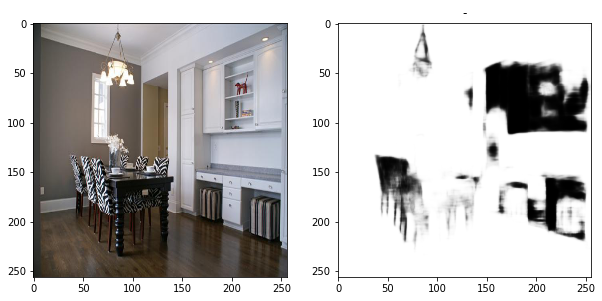

0.0138753866776824


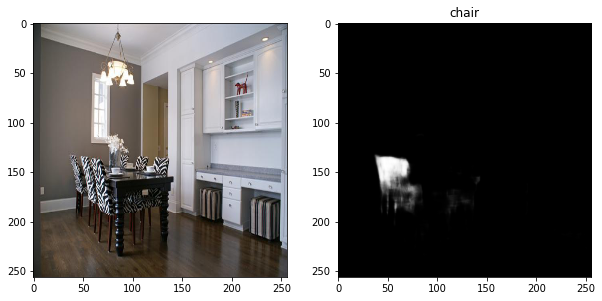

0.0001375227002426982


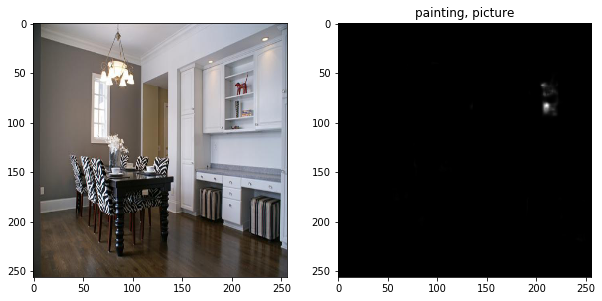

0.10117145627737045


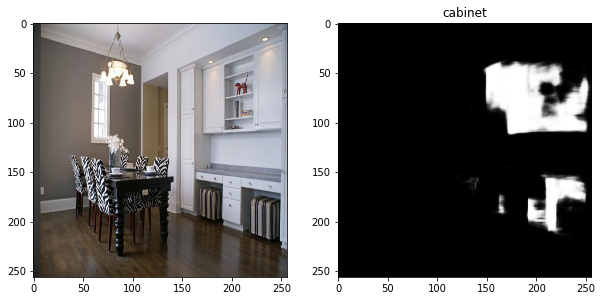

0.010060708038508892


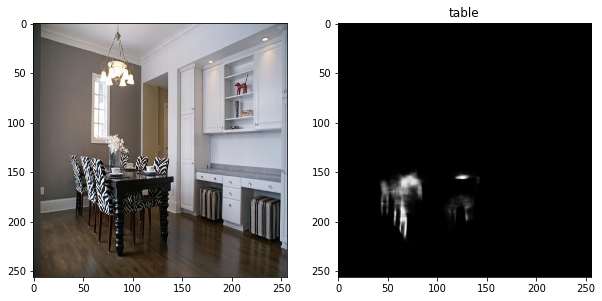

0.002982722595334053


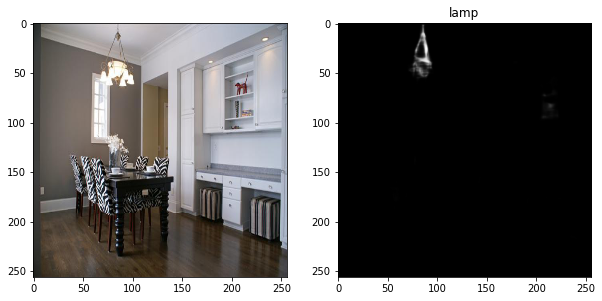

0.005609648302197456


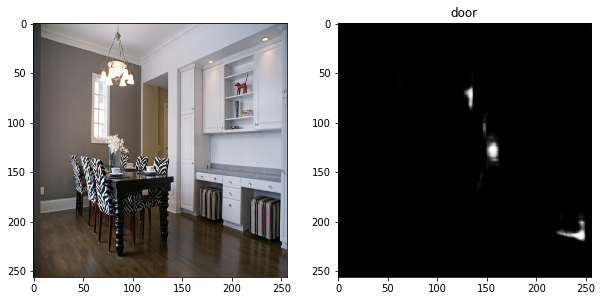

4.426831947057508e-05


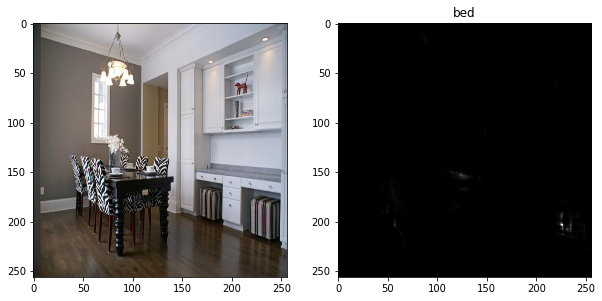

0.0001357018481940031


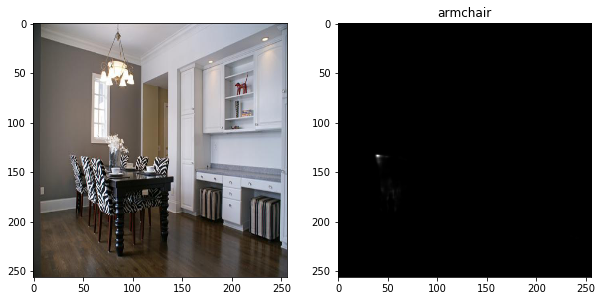

3.415362152736634e-05


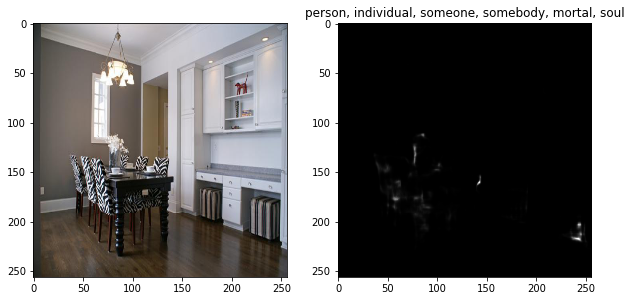

1.1642433491942938e-05


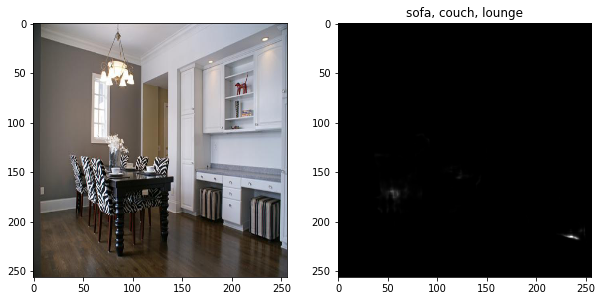

3.2781399568193592e-06


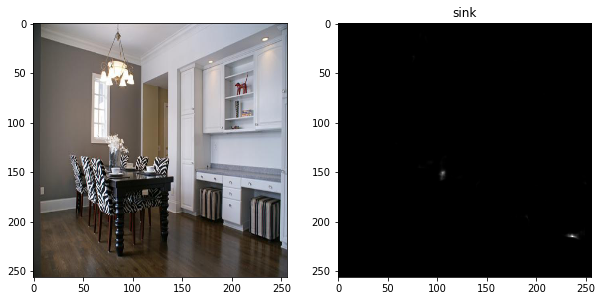

1.8233033188153058e-05


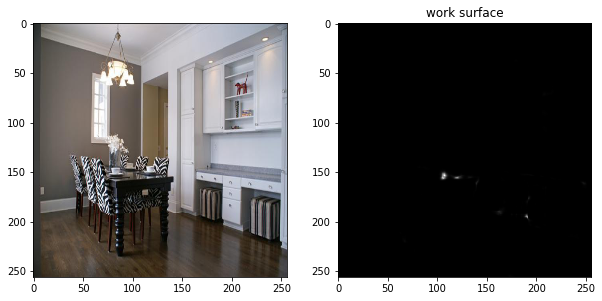

0.0009780472610145807


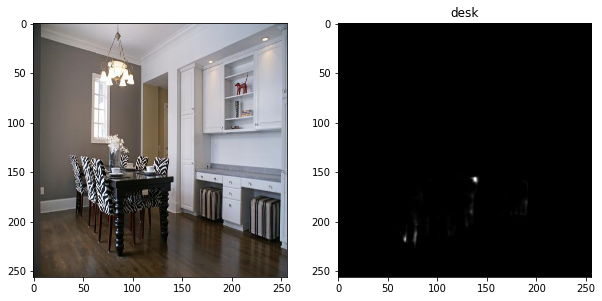

1.679618981142994e-05


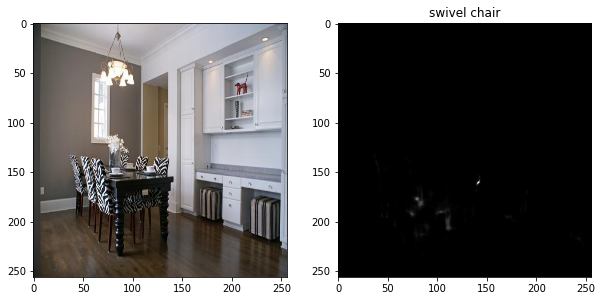

1.387150496157119e-05


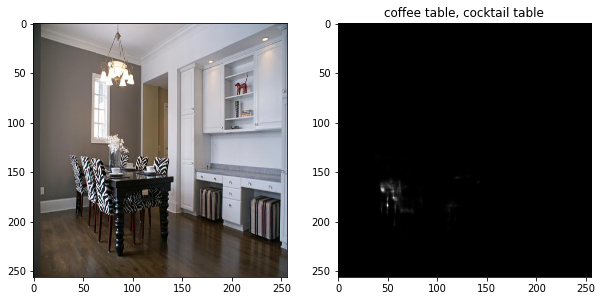

0.0005715101724490523


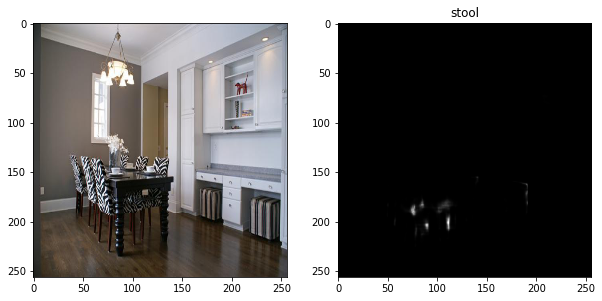

2.0165189198451117e-05


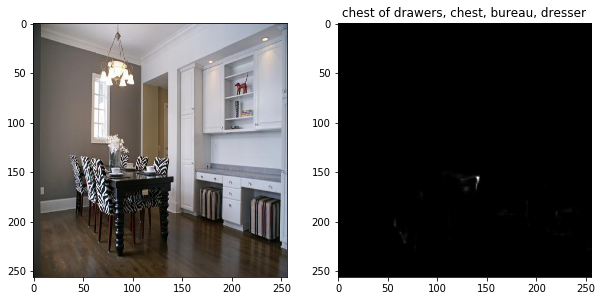

3.164716326864436e-05


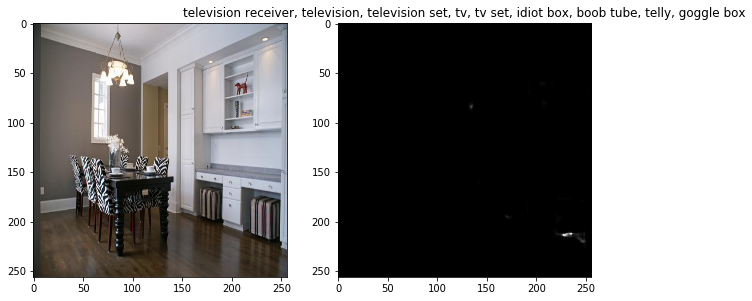

0.0004959049401804805


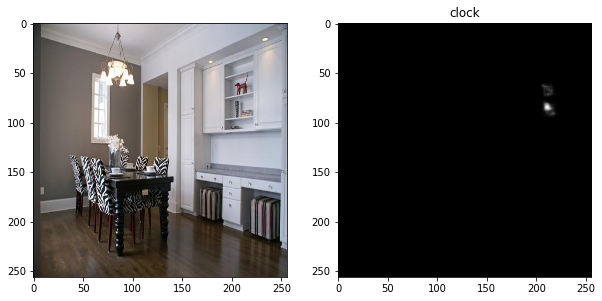

6.341906555462629e-06


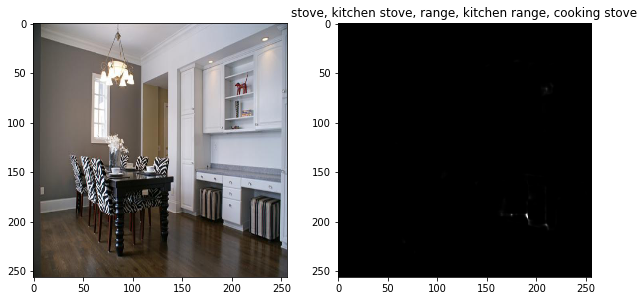

3.3522123885632027e-06


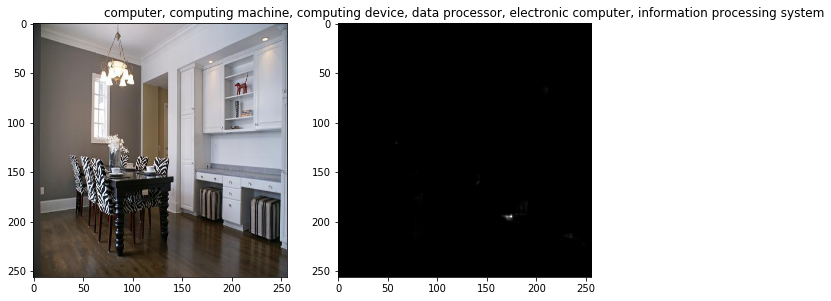

5.340099505701801e-06


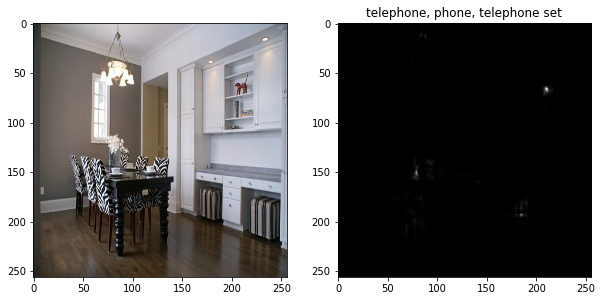

3.498595833661966e-05


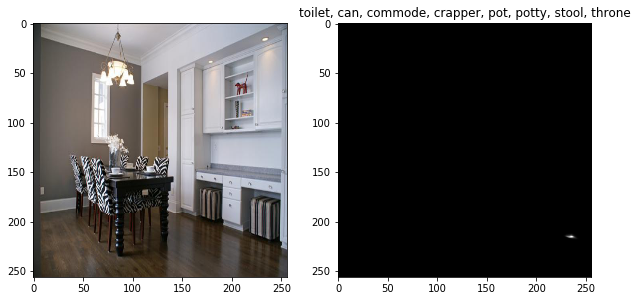

2.607370788609842e-06


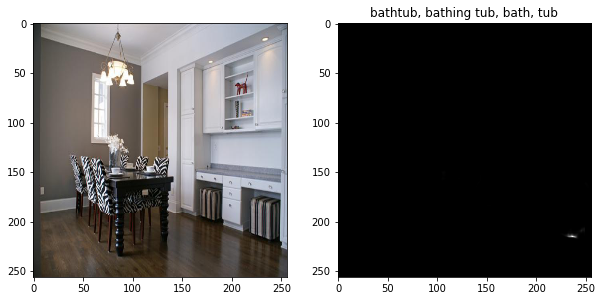

4.6920184104237705e-05


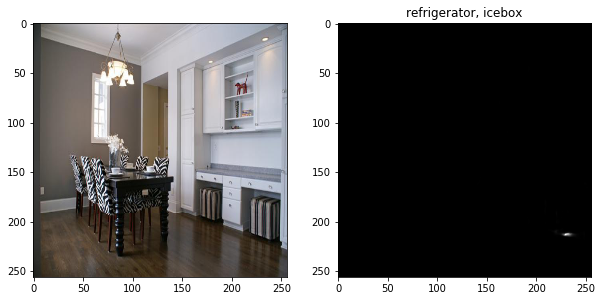

0.0012134213466197252


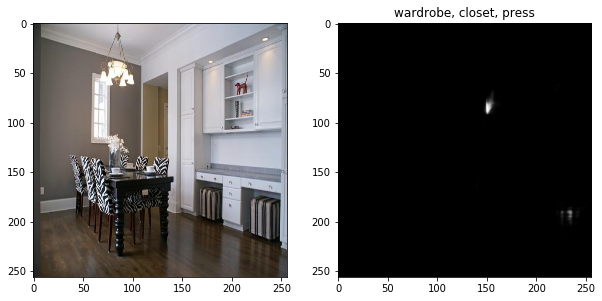

2.902984488173388e-05


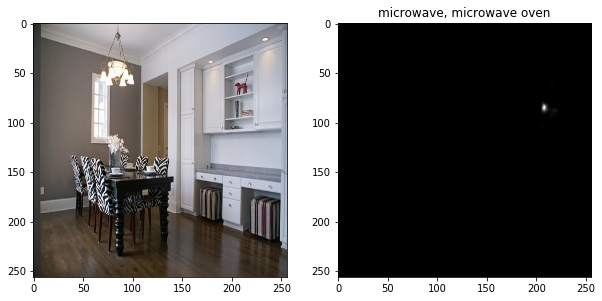

0.006114122923463583


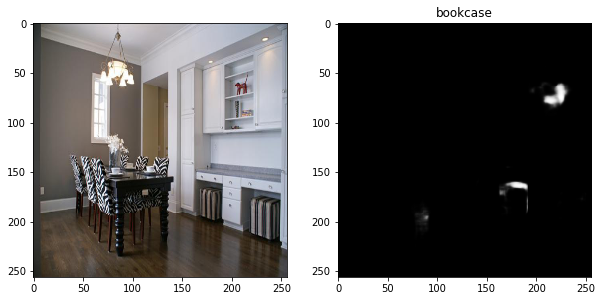

1.570306153553247e-06


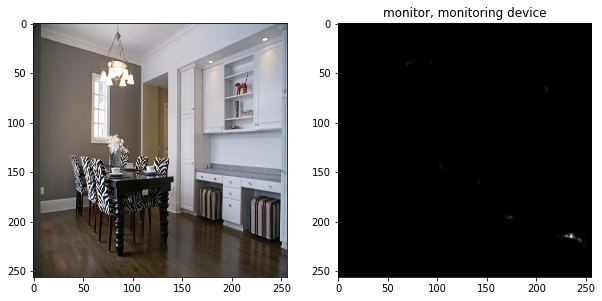

4.4582097302736656e-07


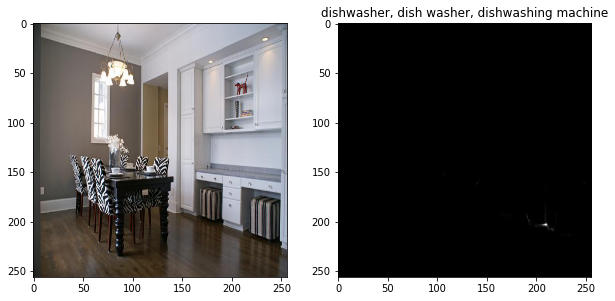

9.833033254835755e-05


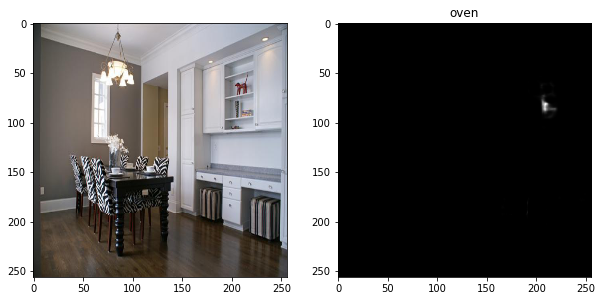

In [46]:
pred = pred_img('data/ADE20K_formated/val/img/img/00001318.jpg')

In [ ]:
ь